# Analyze ParaRel causal tracing results

In [2]:
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import math

from experiments.causal_trace import plot_trace_heatmap

In [3]:
query_file = "/cephyr/users/lovhag/Alvis/projects/rome/data/P19_gpt2_xl_preds.jsonl"

## Load the queries

In [4]:
queries = pd.DataFrame()
with open(query_file) as f:
    for line in f:
        queries = queries.append(json.loads(line), ignore_index=True)
        
queries.head()

,attribute,candidate_p,candidate_prediction,candidate_rank,gold_p,gold_rank,known_id,prediction,prediction_p,prompt,relation_id,subject,template
0,Alexandra,0.024580,London,2.0,0.000011,3197.0,0.0,New,0.038592,Allan Peiper was born in,P19,Allan Peiper,{} was born in
1,Alexandra,0.029013,Canada,2.0,0.000011,3354.0,1.0,the,0.077758,Allan Peiper is originally from,P19,Allan Peiper,{} is originally from
2,Alexandra,0.023173,Canada,2.0,0.000013,3389.0,2.0,the,0.079163,Allan Peiper was originally from,P19,Allan Peiper,{} was originally from
3,Alexandra,0.035623,Canada,2.0,0.000005,4780.0,3.0,the,0.154659,Allan Peiper is native to,P19,Allan Peiper,{} is native to
4,Alexandra,0.032304,Canada,1.0,0.000007,4640.0,4.0,the,0.132673,Allan Peiper was native to,P19,Allan Peiper,{} was native to


### Analyze query data

What to analyze specifically?

#### Do we have any correlations between candidate and gold rankings? (could we look at just one of them?)

In [10]:
queries.drop(columns="known_id").corr(method="pearson")

,candidate_p,candidate_rank,gold_p,gold_rank,prediction_p
candidate_p,1.000000,-0.408575,0.573548,-0.091790,0.099466
candidate_rank,-0.408575,1.000000,-0.247223,0.296463,0.205829
gold_p,0.573548,-0.247223,1.000000,-0.123316,0.069247
gold_rank,-0.091790,0.296463,-0.123316,1.000000,0.115846
prediction_p,0.099466,0.205829,0.069247,0.115846,1.000000


In [11]:
queries.drop(columns="known_id").corr(method="spearman")

,candidate_p,candidate_rank,gold_p,gold_rank,prediction_p
candidate_p,1.000000,-0.888617,0.494890,-0.467413,-0.039573
candidate_rank,-0.888617,1.000000,-0.429356,0.410651,0.110910
gold_p,0.494890,-0.429356,1.000000,-0.988659,-0.004038
gold_rank,-0.467413,0.410651,-0.988659,1.000000,-0.052846
prediction_p,-0.039573,0.110910,-0.004038,-0.052846,1.000000


#### What values do the candidate rankings and gold rankings take?

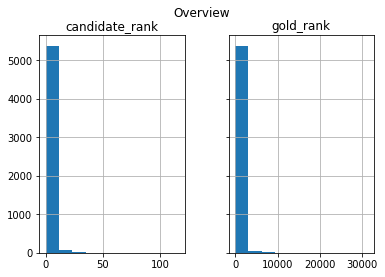

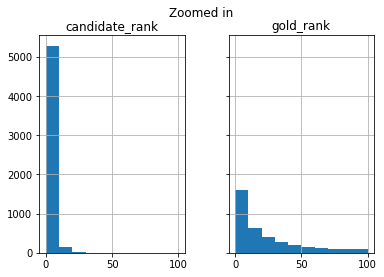

Total number of samples: 5453


In [12]:
hist2 = queries.hist(column=["candidate_rank", "gold_rank"], sharey=True)
plt.suptitle("Overview")
plt.show()

hist = queries.hist(column=["candidate_rank", "gold_rank"], sharey=True, range=[0,100])
plt.suptitle("Zoomed in")
plt.show()
print(f"Total number of samples: {len(queries)}")

### Group model predictions into different categories
Can for example group by:
- TE (model prediction probably not that factual)
- Candidate rank
- Gold rank
- Probability values assigned

Are there correlations between these?

In [13]:
queries["candidate_rank_bin"] = pd.qcut(queries.candidate_rank, 4) # each bin contains equal number of samples
queries["gold_rank_bin"] = pd.qcut(queries.gold_rank, 4)
queries.head()

,attribute,candidate_p,candidate_prediction,candidate_rank,gold_p,gold_rank,known_id,prediction,prediction_p,prompt,relation_id,subject,template,candidate_rank_bin,gold_rank_bin
0,Alexandra,0.024580,London,2.0,0.000011,3197.0,0.0,New,0.038592,Allan Peiper was born in,P19,Allan Peiper,{} was born in,"(1.0, 3.0]","(162.0, 31236.0]"
1,Alexandra,0.029013,Canada,2.0,0.000011,3354.0,1.0,the,0.077758,Allan Peiper is originally from,P19,Allan Peiper,{} is originally from,"(1.0, 3.0]","(162.0, 31236.0]"
2,Alexandra,0.023173,Canada,2.0,0.000013,3389.0,2.0,the,0.079163,Allan Peiper was originally from,P19,Allan Peiper,{} was originally from,"(1.0, 3.0]","(162.0, 31236.0]"
3,Alexandra,0.035623,Canada,2.0,0.000005,4780.0,3.0,the,0.154659,Allan Peiper is native to,P19,Allan Peiper,{} is native to,"(1.0, 3.0]","(162.0, 31236.0]"
4,Alexandra,0.032304,Canada,1.0,0.000007,4640.0,4.0,the,0.132673,Allan Peiper was native to,P19,Allan Peiper,{} was native to,"(-0.001, 1.0]","(162.0, 31236.0]"


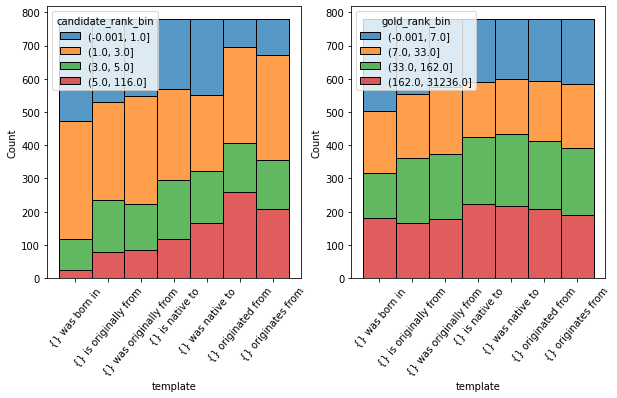

In [14]:
plt.figure(figsize=(10, 5))
ax = plt.subplot(1,2,1)
sns.histplot(data=queries, x="template", hue="candidate_rank_bin", multiple="stack")
plt.xticks(rotation=50)

ax = plt.subplot(1,2,2)
sns.histplot(data=queries, x="template", hue="gold_rank_bin", multiple="stack")
plt.xticks(rotation=50)
plt.show()

Potentially, the templates "{} is native to", "{} was native to" and "{} originated from" are more problematic for GPT2-XL.

In [8]:
cat_val = queries.candidate_rank_bin.cat.categories[0]
queries[queries.candidate_rank_bin==cat_val]

,attribute,candidate_p,candidate_prediction,candidate_rank,gold_p,gold_rank,known_id,prediction,prediction_p,prompt,relation_id,subject,template,candidate_rank_bin,gold_rank_bin
1,Alexandra,0.040801,Chicago,1.0,6.400000e-07,15598.0,1.0,the,0.273378,Allan Peiper is originally from,P19,Allan Peiper,{} is originally from,"(-0.001, 6.0]","(4780.0, 16314.0]"
9,Scotland,0.018402,India,4.0,3.753400e-04,210.0,9.0,the,0.188557,Paul Mounsey was originally from,P19,Paul Mounsey,{} was originally from,"(-0.001, 6.0]","(-0.001, 423.0]"
21,Vienna,0.024330,Germany,2.0,5.587770e-03,11.0,21.0,the,0.054772,Kurt Schwertsik was born in,P19,Kurt Schwertsik,{} was born in,"(-0.001, 6.0]","(-0.001, 423.0]"
22,Vienna,0.039167,Germany,1.0,2.687580e-03,63.0,22.0,the,0.087899,Kurt Schwertsik is originally from,P19,Kurt Schwertsik,{} is originally from,"(-0.001, 6.0]","(-0.001, 423.0]"
23,Vienna,0.033115,Germany,1.0,2.828450e-03,60.0,23.0,the,0.094075,Kurt Schwertsik was originally from,P19,Kurt Schwertsik,{} was originally from,"(-0.001, 6.0]","(-0.001, 423.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5440,Dublin,0.020274,Chicago,5.0,3.139000e-05,1465.0,5440.0,the,0.132704,Lorraine Pilkington is originally from,P19,Lorraine Pilkington,{} is originally from,"(-0.001, 6.0]","(423.0, 4780.0]"
5446,Lisbon,0.045418,Lisbon,2.0,4.541760e-02,2.0,5446.0,the,0.085641,Lopo Soares de Albergaria was born in,P19,Lopo Soares de Albergaria,{} was born in,"(-0.001, 6.0]","(-0.001, 423.0]"
5447,Lisbon,0.032361,Lisbon,5.0,3.236125e-02,5.0,5447.0,Brazil,0.199201,Lopo Soares de Albergaria is originally from,P19,Lopo Soares de Albergaria,{} is originally from,"(-0.001, 6.0]","(-0.001, 423.0]"
5448,Lisbon,0.029673,Lisbon,5.0,2.967252e-02,5.0,5448.0,Brazil,0.185048,Lopo Soares de Albergaria was originally from,P19,Lopo Soares de Albergaria,{} was originally from,"(-0.001, 6.0]","(-0.001, 423.0]"


## Load the causal tracing results

In [18]:
results_folder = "/cephyr/users/lovhag/Alvis/projects/rome/data/results/gpt2-xl/P19/causal_trace_pararel_1659238"
results = np.load(os.path.join(results_folder, "cases/0_any.npz"), allow_pickle=True)

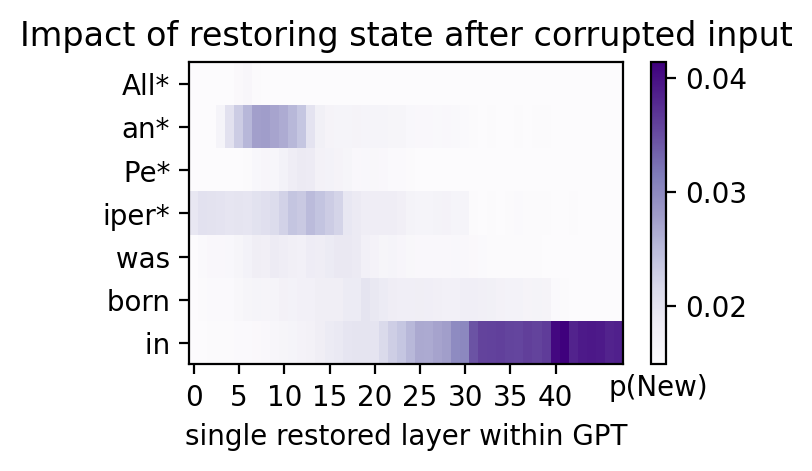

In [17]:
plot_trace_heatmap(results)

### Add treatment effect values to main data

In [23]:
max_num_with_te = 254

te = {"any": [], "candidate": [], "gold": []}
for key in te:
    te[key] = [None]*len(queries)

for i in range(max_num_with_te):
    for key in te:
        results = np.load(os.path.join(results_folder, f"cases/{i}_{key}.npz"), allow_pickle=True)
        te[key][i] = results["high_score"]-results["low_score"]
    
for key in te:
    queries[f"te_{key}"] = te[key]

In [25]:
queries.head()

,attribute,candidate_p,candidate_prediction,candidate_rank,gold_p,gold_rank,known_id,prediction,prediction_p,prompt,relation_id,subject,template,candidate_rank_bin,gold_rank_bin,te,te_any,te_candidate,te_gold
0,Alexandra,0.024580,London,2.0,0.000011,3197.0,0.0,New,0.038592,Allan Peiper was born in,P19,Allan Peiper,{} was born in,"(1.0, 3.0]","(162.0, 31236.0]",0.023766,0.023766,0.017587,1.760426e-06
1,Alexandra,0.029013,Canada,2.0,0.000011,3354.0,1.0,the,0.077758,Allan Peiper is originally from,P19,Allan Peiper,{} is originally from,"(1.0, 3.0]","(162.0, 31236.0]",-0.111225,-0.111225,0.022092,7.177561e-07
2,Alexandra,0.023173,Canada,2.0,0.000013,3389.0,2.0,the,0.079163,Allan Peiper was originally from,P19,Allan Peiper,{} was originally from,"(1.0, 3.0]","(162.0, 31236.0]",-0.105877,-0.105877,0.017092,7.967853e-07
3,Alexandra,0.035623,Canada,2.0,0.000005,4780.0,3.0,the,0.154659,Allan Peiper is native to,P19,Allan Peiper,{} is native to,"(1.0, 3.0]","(162.0, 31236.0]",-0.188861,-0.188861,0.031306,3.093775e-06
4,Alexandra,0.032304,Canada,1.0,0.000007,4640.0,4.0,the,0.132673,Allan Peiper was native to,P19,Allan Peiper,{} was native to,"(-0.001, 1.0]","(162.0, 31236.0]",-0.250188,-0.250188,0.028819,4.418401e-06


<AxesSubplot:xlabel='candidate_p', ylabel='te_candidate'>

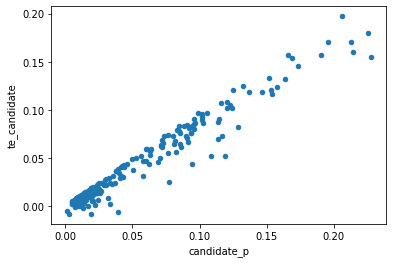

In [29]:
queries[:max_num_with_te].plot.scatter(x="candidate_p", y="te_candidate")

<AxesSubplot:xlabel='gold_p', ylabel='te_gold'>

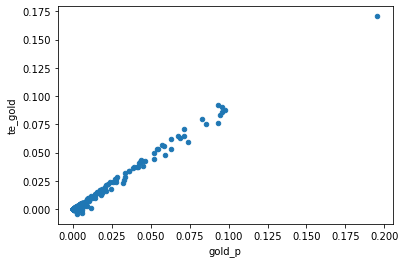

In [30]:
queries[:max_num_with_te].plot.scatter(x="gold_p", y="te_gold")

In [31]:
queries.groupby("subject").std()

,candidate_p,candidate_rank,gold_p,gold_rank,known_id,prediction_p,te,te_any,te_candidate,te_gold
subject,,,,,,,,,,
Aaron King,0.009321,2.058663,0.000415,25.414656,2.160247,0.055639,NaN,NaN,NaN,NaN
Aaron Parks,0.002135,1.069045,0.001164,4.855042,2.160247,0.061945,NaN,NaN,NaN,NaN
Abbas Ahmed Atwi,0.006958,5.318432,0.001846,18.091040,2.160247,0.038820,NaN,NaN,NaN,NaN
Abd al-Qadir al-Husayni,0.007769,0.786796,0.000595,21.106307,2.160247,0.038186,NaN,NaN,NaN,NaN
Abd el-Ouahed ben Messaoud,0.006697,0.534522,0.009142,1.380131,2.160247,0.053492,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
Yui Ichikawa,0.061532,0.534522,0.031878,1.069045,2.160247,0.045824,NaN,NaN,NaN,NaN
Yvonne Blake,0.002780,1.799471,0.000585,17.994708,2.160247,0.049711,NaN,NaN,NaN,NaN
Zehra Sheerazi,0.012370,0.755929,0.001021,26.560802,2.160247,0.050846,NaN,NaN,NaN,NaN


## Get queries for which TE is significant

In [35]:
queries[queries.subject=="Claude Arrieu"]

,attribute,candidate_p,candidate_prediction,candidate_rank,gold_p,gold_rank,known_id,prediction,prediction_p,prompt,relation_id,subject,template,candidate_rank_bin,gold_rank_bin,te,te_any,te_candidate,te_gold
28,Paris,0.195481,Paris,0.0,0.195481,0.0,28.0,Paris,0.195481,Claude Arrieu was born in,P19,Claude Arrieu,{} was born in,"(-0.001, 1.0]","(-0.001, 7.0]",0.170611,0.170611,0.170611,0.170611
29,Paris,0.225198,France,0.0,0.073581,2.0,29.0,France,0.225198,Claude Arrieu is originally from,P19,Claude Arrieu,{} is originally from,"(-0.001, 1.0]","(-0.001, 7.0]",0.179877,0.179877,0.179877,0.059713
30,Paris,0.163905,France,0.0,0.059420,2.0,30.0,France,0.163905,Claude Arrieu was originally from,P19,Claude Arrieu,{} was originally from,"(-0.001, 1.0]","(-0.001, 7.0]",0.131965,0.131965,0.131965,0.048267
31,Paris,0.190283,France,0.0,0.058785,2.0,31.0,France,0.190283,Claude Arrieu is native to,P19,Claude Arrieu,{} is native to,"(-0.001, 1.0]","(-0.001, 7.0]",0.157368,0.157368,0.157368,0.056156
32,Paris,0.114440,France,1.0,0.041610,2.0,32.0,the,0.197732,Claude Arrieu was native to,P19,Claude Arrieu,{} was native to,"(-0.001, 1.0]","(-0.001, 7.0]",-0.115397,-0.115397,0.090453,0.037160
33,Paris,0.120554,France,1.0,0.036106,3.0,33.0,the,0.205169,Claude Arrieu originated from,P19,Claude Arrieu,{} originated from,"(-0.001, 1.0]","(-0.001, 7.0]",-0.072215,-0.072215,0.108016,0.033827
34,Paris,0.122599,France,1.0,0.046452,3.0,34.0,the,0.207858,Claude Arrieu originates from,P19,Claude Arrieu,{} originates from,"(-0.001, 1.0]","(-0.001, 7.0]",-0.115664,-0.115664,0.105127,0.042571


In [36]:
queries[queries.subject=="Masako Natsume"]

,attribute,candidate_p,candidate_prediction,candidate_rank,gold_p,gold_rank,known_id,prediction,prediction_p,prompt,relation_id,subject,template,candidate_rank_bin,gold_rank_bin,te,te_any,te_candidate,te_gold
98,Tokyo,0.095875,Tokyo,0.0,0.095875,0.0,98.0,Tokyo,0.095875,Masako Natsume was born in,P19,Masako Natsume,{} was born in,"(-0.001, 1.0]","(-0.001, 7.0]",0.085725,0.085725,0.085725,0.085725
99,Tokyo,0.113535,Japan,0.0,0.097948,1.0,99.0,Japan,0.113535,Masako Natsume is originally from,P19,Masako Natsume,{} is originally from,"(-0.001, 1.0]","(-0.001, 7.0]",0.069547,0.069547,0.069547,0.087747
100,Tokyo,0.082613,Japan,1.0,0.071358,2.0,100.0,the,0.121861,Masako Natsume was originally from,P19,Masako Natsume,{} was originally from,"(-0.001, 1.0]","(-0.001, 7.0]",-0.066544,-0.066544,0.055935,0.065158
101,Tokyo,0.227581,Japan,0.0,0.071646,2.0,101.0,Japan,0.227581,Masako Natsume is native to,P19,Masako Natsume,{} is native to,"(-0.001, 1.0]","(-0.001, 7.0]",0.155047,0.155047,0.155047,0.070667
102,Tokyo,0.116532,Japan,1.0,0.042211,2.0,102.0,the,0.190870,Masako Natsume was native to,P19,Masako Natsume,{} was native to,"(-0.001, 1.0]","(-0.001, 7.0]",-0.151506,-0.151506,0.072585,0.041224
103,Tokyo,0.081358,Japan,2.0,0.043899,3.0,103.0,the,0.200645,Masako Natsume originated from,P19,Masako Natsume,{} originated from,"(1.0, 3.0]","(-0.001, 7.0]",-0.107328,-0.107328,0.067574,0.043221
104,Tokyo,0.081007,Japan,1.0,0.042827,3.0,104.0,the,0.204779,Masako Natsume originates from,P19,Masako Natsume,{} originates from,"(-0.001, 1.0]","(-0.001, 7.0]",-0.127884,-0.127884,0.065040,0.041899


In [38]:
queries[queries.subject=="Sirindhorn"]

,attribute,candidate_p,candidate_prediction,candidate_rank,gold_p,gold_rank,known_id,prediction,prediction_p,prompt,relation_id,subject,template,candidate_rank_bin,gold_rank_bin,te,te_any,te_candidate,te_gold
175,Bangkok,0.008759,Germany,4.0,0.000187,770.0,175.0,the,0.150236,Sirindhorn was born in,P19,Sirindhorn,{} was born in,"(3.0, 5.0]","(162.0, 31236.0]",-0.022790,-0.022790,0.002889,-2.872661e-05
176,Bangkok,0.020490,Germany,1.0,0.000440,354.0,176.0,the,0.133301,Sirindhorn is originally from,P19,Sirindhorn,{} is originally from,"(-0.001, 1.0]","(162.0, 31236.0]",-0.041675,-0.041675,0.004870,1.132882e-04
177,Bangkok,0.013650,Germany,2.0,0.000186,772.0,177.0,the,0.170629,Sirindhorn was originally from,P19,Sirindhorn,{} was originally from,"(1.0, 3.0]","(162.0, 31236.0]",0.001276,0.001276,0.003388,-1.065621e-05
178,Bangkok,0.002444,India,33.0,0.000009,3742.0,178.0,the,0.471573,Sirindhorn is native to,P19,Sirindhorn,{} is native to,"(5.0, 116.0]","(162.0, 31236.0]",0.112425,0.112425,-0.008190,-2.095295e-05
179,Bangkok,0.000982,India,97.0,0.000005,5181.0,179.0,the,0.401895,Sirindhorn was native to,P19,Sirindhorn,{} was native to,"(5.0, 116.0]","(162.0, 31236.0]",0.021579,0.021579,-0.004893,-1.564566e-05
180,Bangkok,0.004955,India,5.0,0.000018,3268.0,180.0,the,0.362888,Sirindhorn originated from,P19,Sirindhorn,{} originated from,"(3.0, 5.0]","(162.0, 31236.0]",0.079272,0.079272,0.002361,-8.938744e-07
181,Bangkok,0.004710,India,8.0,0.000023,2669.0,181.0,the,0.379714,Sirindhorn originates from,P19,Sirindhorn,{} originates from,"(5.0, 116.0]","(162.0, 31236.0]",0.043692,0.043692,0.001994,-1.725806e-06


## Analyze causal tracing results

- When the model is consistent, can we observe that it treats the queries similarly? (Compared to the case when the model is not consistent)
    - Consider heatmaps
    - Consider direct effect of corrupting the subject

In [40]:
from utils import read_knowledge, plot_array

Average Total Effect 0.1347738410652307
Best average indirect effect on last subject 0.059476887940296104
Best average indirect effect on last token 0.13477403497589485
Average best-fixed score 0.16178045
Average best-fixed on last subject token score 0.08772691
Average best-fixed on last word score 0.16178045
Argmax at last subject token 14
Max at last subject token 0.0864833
Argmax at last prompt token 47
Max at last prompt token 0.16178045


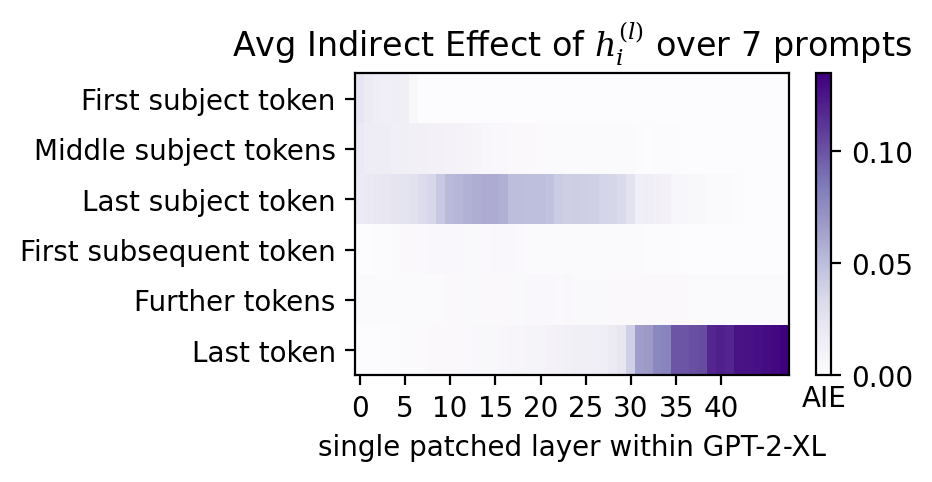

Average Total Effect 0.1347738410652307
Best average indirect effect on last subject 0.04643390899790185
Best average indirect effect on last token 0.028446881233581474
Average best-fixed score 0.077087305
Average best-fixed on last subject token score 0.07344032
Average best-fixed on last word score 0.05725996
Argmax at last subject token 18
Max at last subject token 0.07344032
Argmax at last prompt token 35
Max at last prompt token 0.055453293


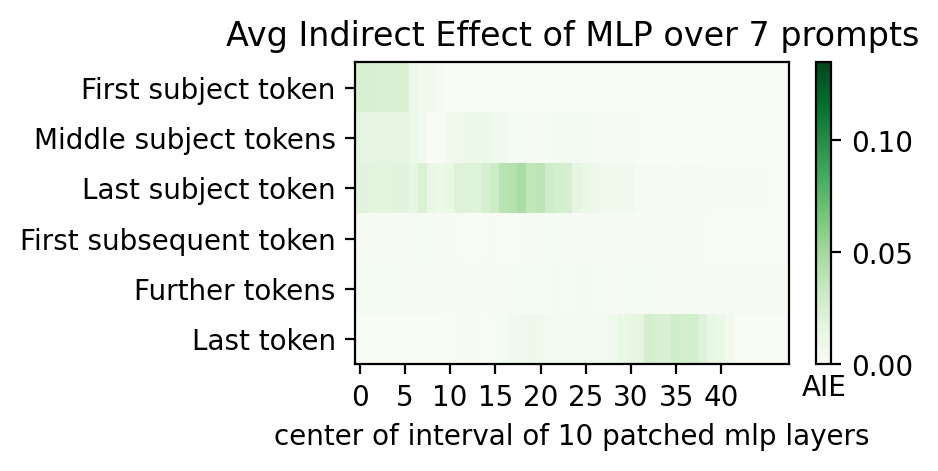

Average Total Effect 0.1347738410652307
Best average indirect effect on last subject 0.014373595028051307
Best average indirect effect on last token 0.07399205690515892
Average best-fixed score 0.10133289
Average best-fixed on last subject token score 0.043403696
Average best-fixed on last word score 0.10133289
Argmax at last subject token 7
Max at last subject token 0.041380007
Argmax at last prompt token 35
Max at last prompt token 0.10099847


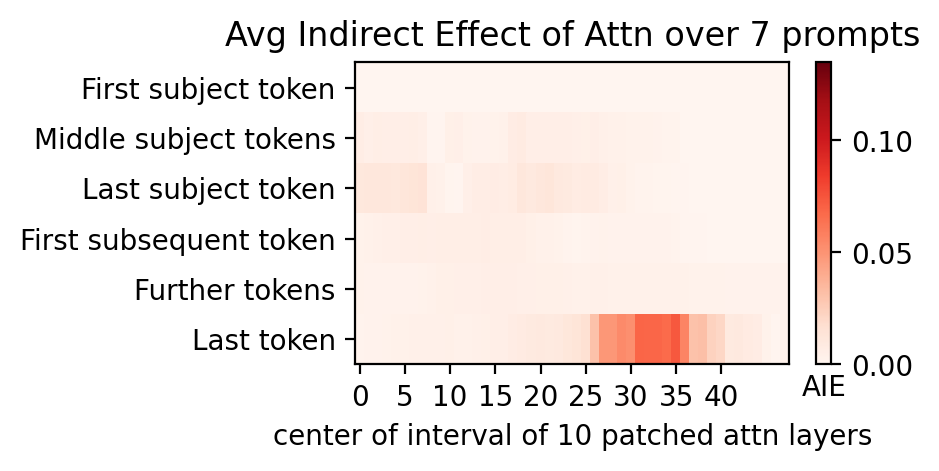

In [76]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# Uncomment the architecture to plot.
archname = "GPT-2-XL"
savefolder = os.path.join(results_folder, "summary_pdfs")
pred_type = "candidate"

indices = list(range(28,35)) #claude arrieu
#indices = list(range(175, 182)) #sirindhorn

# arch = 'EleutherAI_gpt-j-6B'
# archname = 'GPT-J-6B'

# arch = 'EleutherAI_gpt-neox-20b'
# archname = 'GPT-NeoX-20B'

high_score = None  # Scale all plots according to the y axis of the first plot

for kind in [None, "mlp", "attn"]:
    d = read_knowledge(indices, kind, os.path.join(results_folder, "cases"), pred_type)
    count = d["size"]
    what = {
        None: "Indirect Effect of $h_i^{(l)}$",
        "mlp": "Indirect Effect of MLP",
        "attn": "Indirect Effect of Attn",
    }[kind]
    title = f"Avg {what} over {count} prompts"
    result = np.clip(d["result"] - d["low_score"], 0, None)
    kindcode = "" if kind is None else f"_{kind}"
    if kind not in ["mlp", "attn"]:
        high_score = result.max()
    plot_array(
        result,
        kind=kind,
        title=title,
        low_score=0.0,
        high_score=high_score,
        archname=archname,
        savepdf=os.path.join(savefolder, f"rollup{kindcode}.pdf"),
    )

As a line graph with standard deviations

Reading None
Average Total Effect 0.0003456798345937047
Best average indirect effect on last subject 0.00811478029936552
Best average indirect effect on last token 0.0012496467679738998
Average best-fixed score 0.023091305
Average best-fixed on last subject token score 0.017392263
Average best-fixed on last word score 0.011333866
Argmax at last subject token 4
Max at last subject token 0.015767723
Argmax at last prompt token 31
Max at last prompt token 0.00890259
Reading mlp
Average Total Effect 0.0003456798345937047
Best average indirect effect on last subject 0.0050543444231152534
Best average indirect effect on last token 0.00176328606903553
Average best-fixed score 0.019455587
Average best-fixed on last subject token score 0.014156831
Average best-fixed on last word score 0.010345719
Argmax at last subject token 5
Max at last subject token 0.012707287
Argmax at last prompt token 19
Max at last prompt token 0.009416229
Reading attn
Average Total Effect 0.0003456798345937047
Best ave

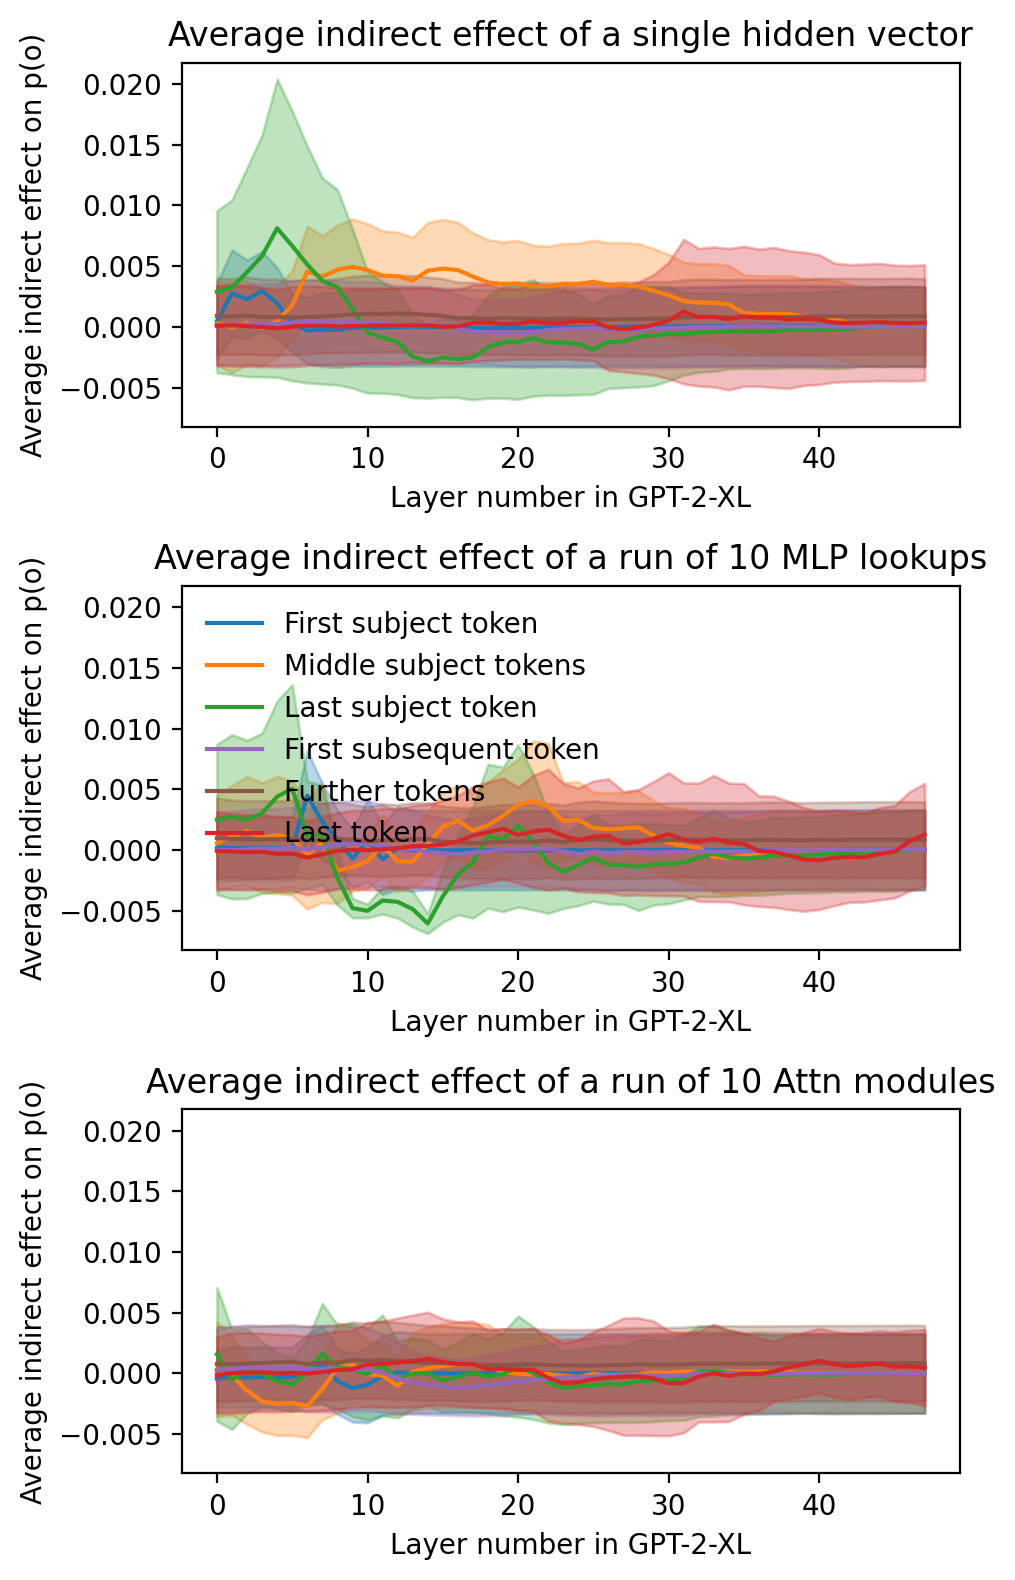

In [74]:
import math

labels = [
    "First subject token",
    "Middle subject tokens",
    "Last subject token",
    "First subsequent token",
    "Further tokens",
    "Last token",
]
color_order = [0, 1, 2, 4, 5, 3]
x = None

cmap = plt.get_cmap("tab10")
fig, axes = plt.subplots(3, 1, figsize=(5, 8), sharey=True, dpi=200)
for j, (kind, title) in enumerate(
    [
        (None, "single hidden vector"),
        ("mlp", "run of 10 MLP lookups"),
        ("attn", "run of 10 Attn modules"),
    ]
):
    print(f"Reading {kind}")
    d = read_knowledge(indices, kind, os.path.join(results_folder, "cases"), pred_type)
    for i, label in list(enumerate(labels)):
        y = d["result"][i] - d["low_score"]
        if x is None:
            x = list(range(len(y)))
        std = d["result_std"][i]
        error = std * 1.96 / math.sqrt(count)
        axes[j].fill_between(
            x, y - error, y + error, alpha=0.3, color=cmap.colors[color_order[i]]
        )
        axes[j].plot(x, y, label=label, color=cmap.colors[color_order[i]])

    axes[j].set_title(f"Average indirect effect of a {title}")
    axes[j].set_ylabel("Average indirect effect on p(o)")
    axes[j].set_xlabel(f"Layer number in {archname}")
    # axes[j].set_ylim(0.1, 0.3)
axes[1].legend(frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(savefolder, "lineplot-causaltrace.pdf"))
plt.show()

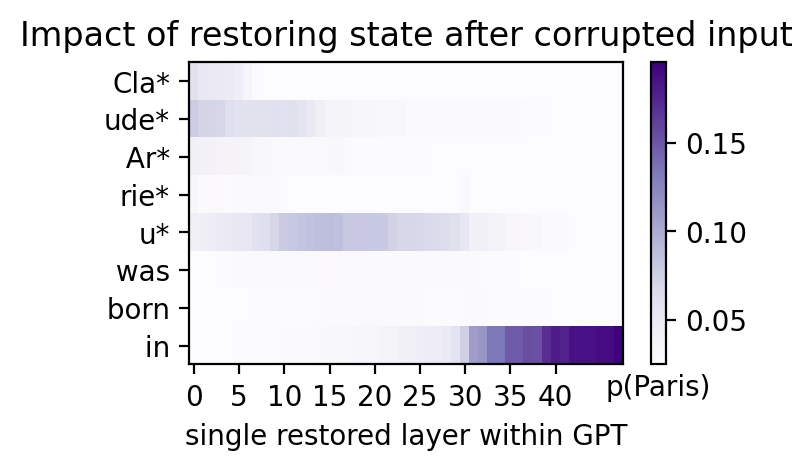

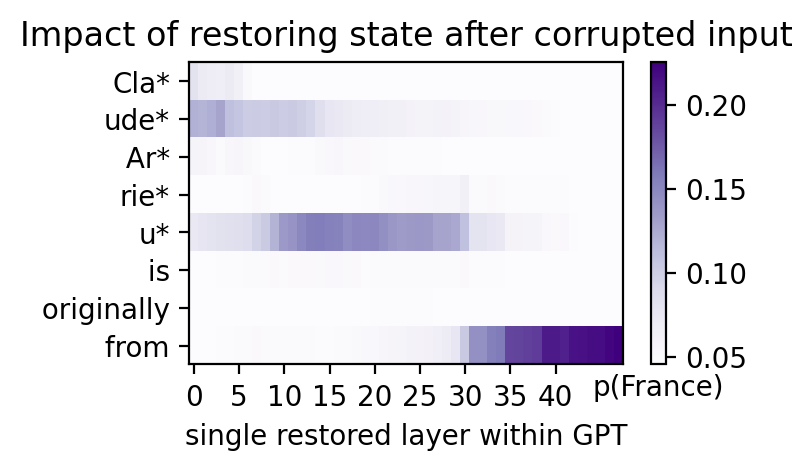

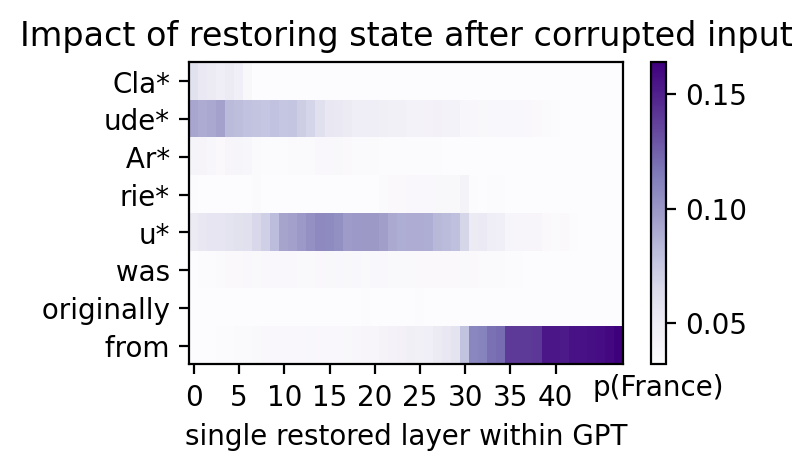

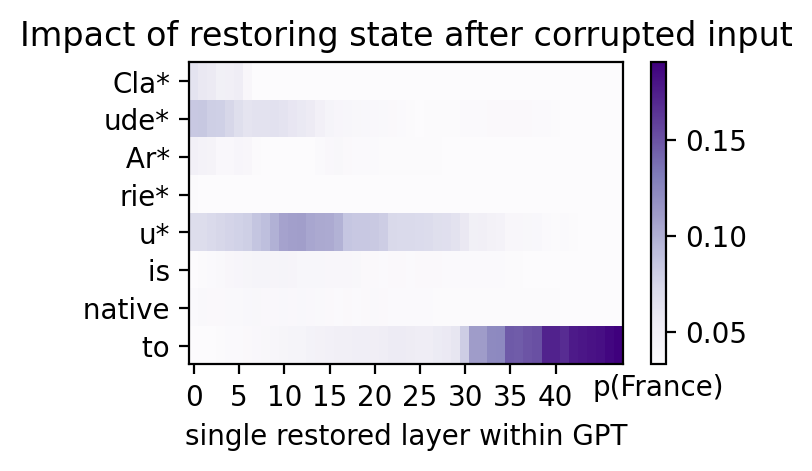

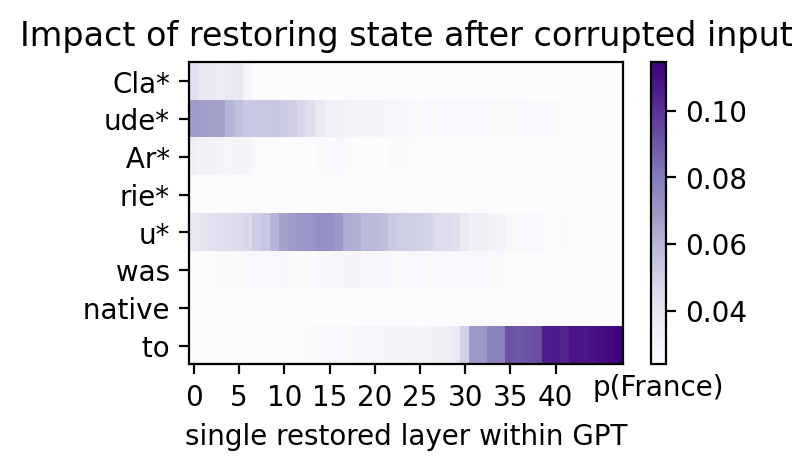

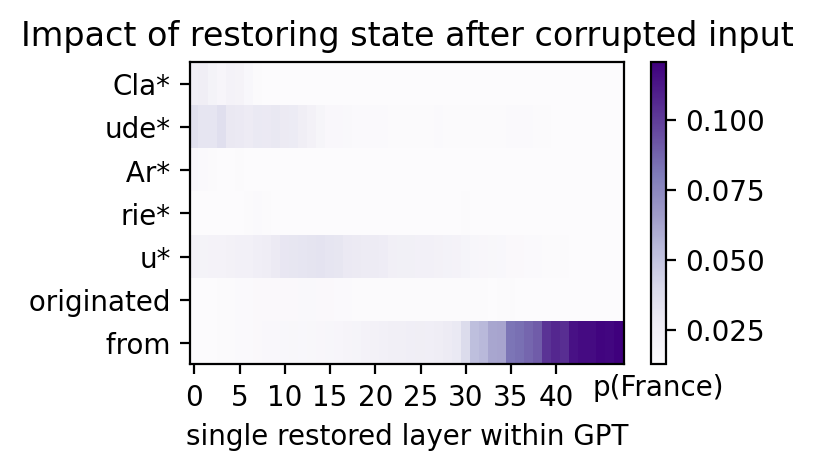

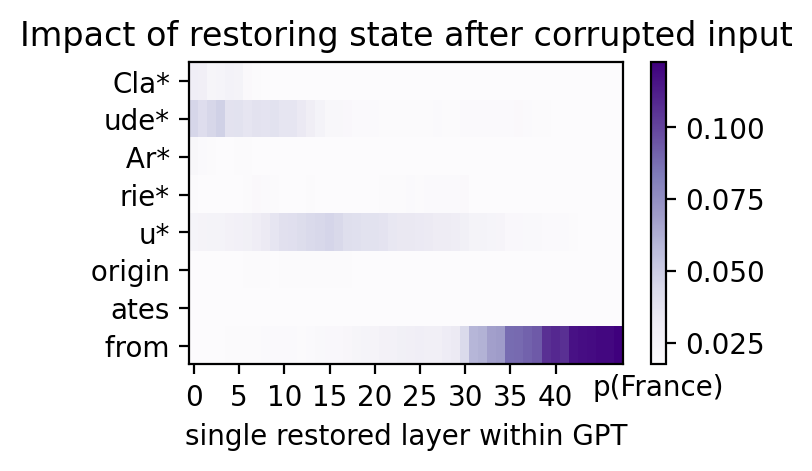

In [51]:
for i in indices:
    results = np.load(os.path.join(results_folder, f"cases/{i}_candidate.npz"), allow_pickle=True)
    plot_trace_heatmap(results)

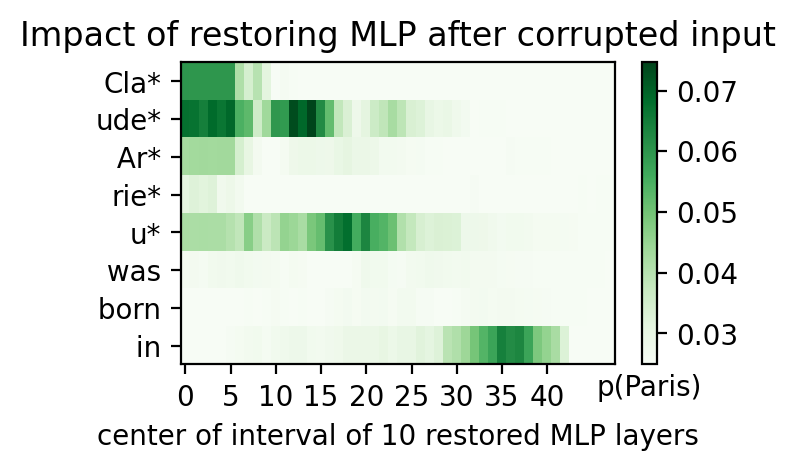

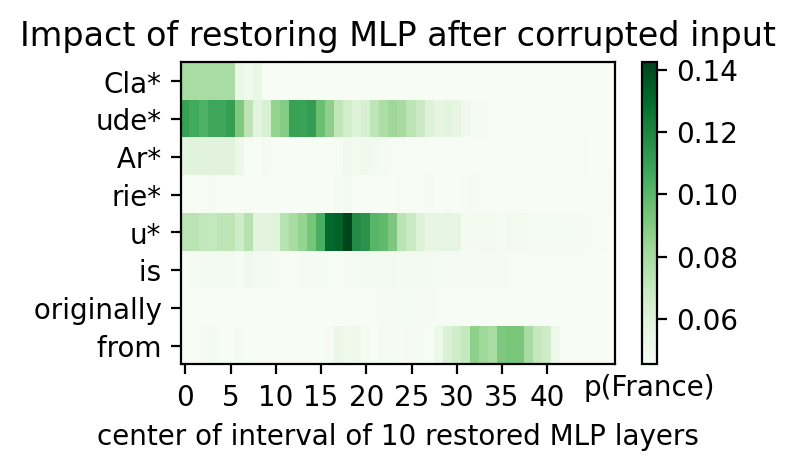

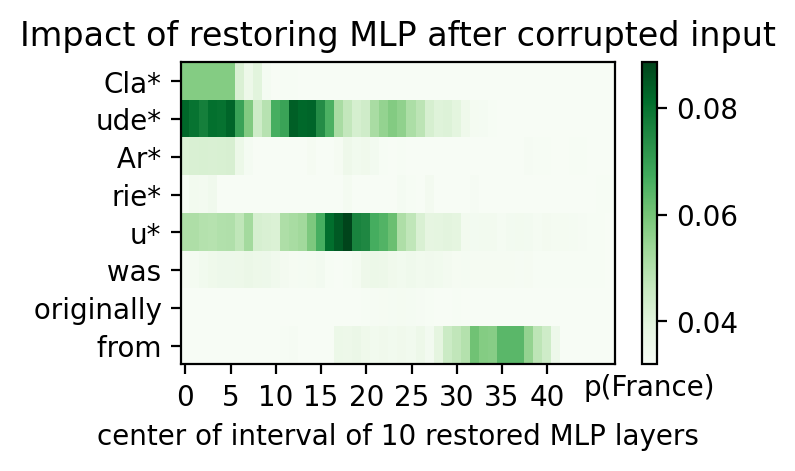

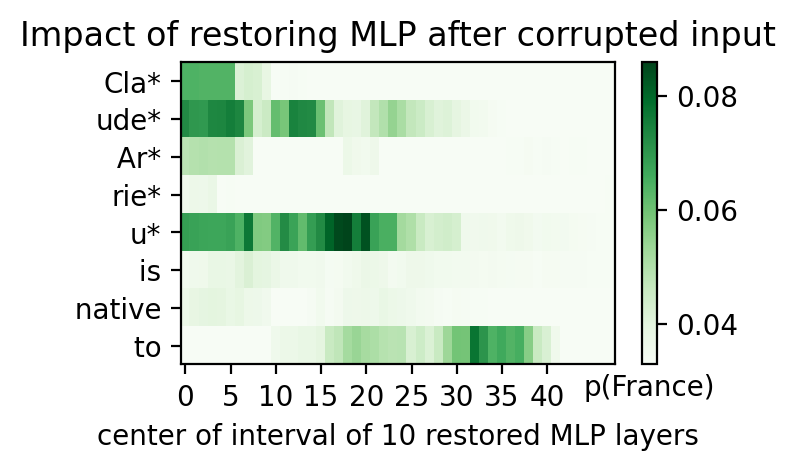

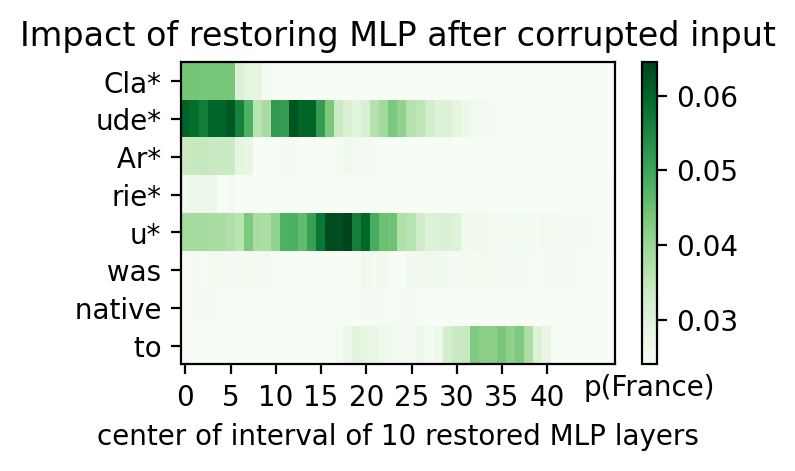

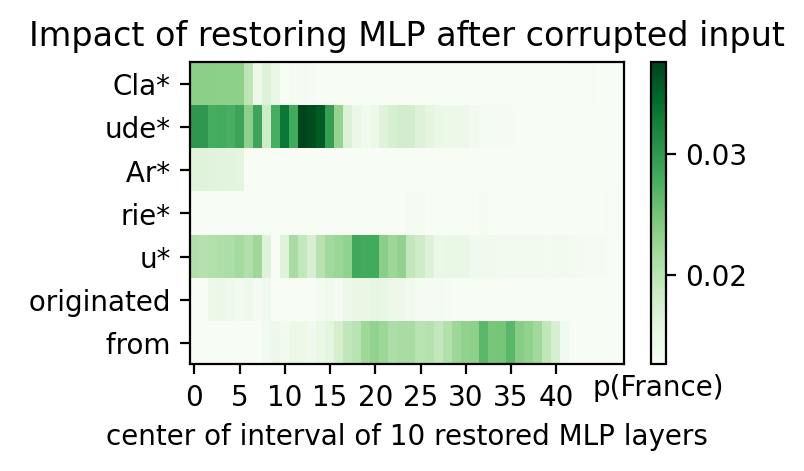

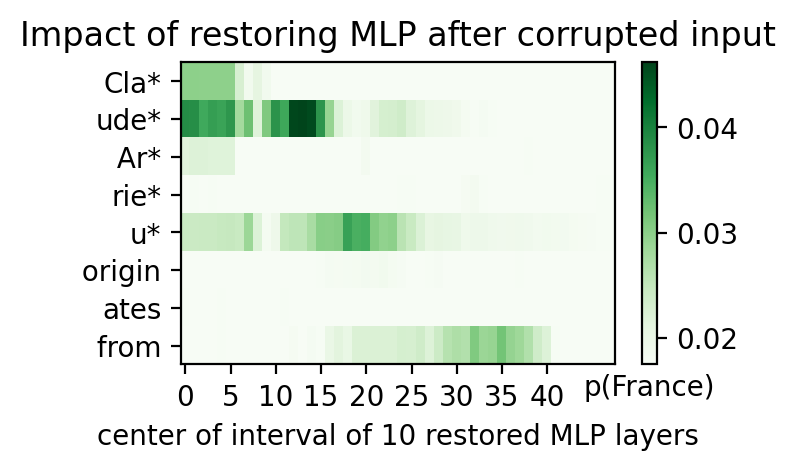

In [77]:
for i in indices:
    results = np.load(os.path.join(results_folder, f"cases/{i}_candidate_mlp.npz"), allow_pickle=True)
    plot_trace_heatmap(results)